In [126]:
from sentence_transformers import SentenceTransformer

model = "sentence-transformers/all-MiniLM-L6-v2"


model = SentenceTransformer(model)
text = """Positional control of pneumatic manipulators for construction tasks
This paper describes solutions that can be applied to pneumatic manipulator
	problems in positioning, both for angle trajectories and for long
	linear trajectories, used in construction tasks. Optimal positioning of
	a pneumatic manipulator along angle trajectories with minimum control
	energy consumption is given. The implementation of the control system
	is presented. Control algorithms for a long linear trajectory
	manipulator based on two-phase and three-phase motion modes of the
	end-effector are investigated. Conventional and fuzzy logic controls of
	a pneumatic manipulator were applied and experimental testing was
	carried out. The obtained results allow widening the application range
	of pneumatic manipulators in construction, particularly in gantry type
	machines"""
 
tokenizer = model.tokenizer
from tqdm import tqdm

In [127]:
target = model.encode(text, convert_to_tensor=True)

In [128]:
import torch
from torch.nn import CosineSimilarity

naive_best_token = None
naive_best_cossim = float("-inf")

cossims = []

model.eval()
model.cuda()
for token in tqdm(range(len(tokenizer.vocab))):
    with torch.no_grad():
        input_ids = torch.tensor([101, token, 102]).unsqueeze(0).to(model.device)
        attention_mask = input_ids != 0
        output = model({
            "input_ids": input_ids,
            "attention_mask": attention_mask
        })["sentence_embedding"]
        cossim = CosineSimilarity()(output, target)
        cossims.append(cossim)
        if cossim > naive_best_cossim:
            naive_best_cossim = cossim
            naive_best_token = token
import numpy as np
cossims = [
    cossim.item()
    for cossim in cossims
]

  0%|          | 0/30522 [00:00<?, ?it/s]

100%|██████████| 30522/30522 [02:51<00:00, 178.13it/s]


In [129]:
tokenizer.decode(np.array(cossims).argmax())

'positioning'

In [130]:
output = model.encode(tokenizer.decode(np.array(cossims).argmax()))
print(CosineSimilarity()(torch.Tensor(output).cuda().unsqueeze(0), target.unsqueeze(0)).item())

0.31916874647140503


In [132]:
unused_token = next(
    k for k, v in tokenizer.vocab.items()
    if "[unused" in k)
unused_token_id = tokenizer.vocab[unused_token]
new_token_id = unused_token_id

  1%|          | 2/200 [00:00<00:32,  6.12it/s]

Epoch 0 Similarity -0.14152312278747559


  8%|▊         | 16/200 [00:00<00:05, 31.68it/s]

Epoch 10 Similarity 0.4470056891441345


 13%|█▎        | 26/200 [00:00<00:04, 37.11it/s]

Epoch 20 Similarity 0.5592376589775085


 18%|█▊        | 36/200 [00:01<00:04, 40.82it/s]

Epoch 30 Similarity 0.520780086517334


 23%|██▎       | 46/200 [00:01<00:03, 42.28it/s]

Epoch 40 Similarity 0.6202535629272461


 28%|██▊       | 56/200 [00:01<00:03, 40.86it/s]

Epoch 50 Similarity 0.5875903367996216


 33%|███▎      | 66/200 [00:01<00:03, 40.95it/s]

Epoch 60 Similarity 0.6064719557762146


 38%|███▊      | 76/200 [00:02<00:02, 42.26it/s]

Epoch 70 Similarity 0.6483274698257446


 43%|████▎     | 86/200 [00:02<00:02, 42.86it/s]

Epoch 80 Similarity 0.611094057559967


 48%|████▊     | 96/200 [00:02<00:02, 41.78it/s]

Epoch 90 Similarity 0.6451724767684937


 53%|█████▎    | 106/200 [00:02<00:02, 43.19it/s]

Epoch 100 Similarity 0.6182727217674255


 58%|█████▊    | 116/200 [00:03<00:02, 41.77it/s]

Epoch 110 Similarity 0.622785210609436


 63%|██████▎   | 126/200 [00:03<00:01, 40.83it/s]

Epoch 120 Similarity 0.6405796408653259


 68%|██████▊   | 136/200 [00:03<00:01, 42.22it/s]

Epoch 130 Similarity 0.5988255739212036


 73%|███████▎  | 146/200 [00:03<00:01, 40.96it/s]

Epoch 140 Similarity 0.6375641226768494


 78%|███████▊  | 156/200 [00:04<00:01, 41.86it/s]

Epoch 150 Similarity 0.6507032513618469


 83%|████████▎ | 166/200 [00:04<00:00, 41.17it/s]

Epoch 160 Similarity 0.6407625079154968


 88%|████████▊ | 176/200 [00:04<00:00, 39.29it/s]

Epoch 170 Similarity 0.6572238206863403


 93%|█████████▎| 186/200 [00:04<00:00, 40.22it/s]

Epoch 180 Similarity 0.6688412427902222


 98%|█████████▊| 196/200 [00:04<00:00, 41.52it/s]

Epoch 190 Similarity 0.6465122699737549


100%|██████████| 200/200 [00:05<00:00, 39.25it/s]


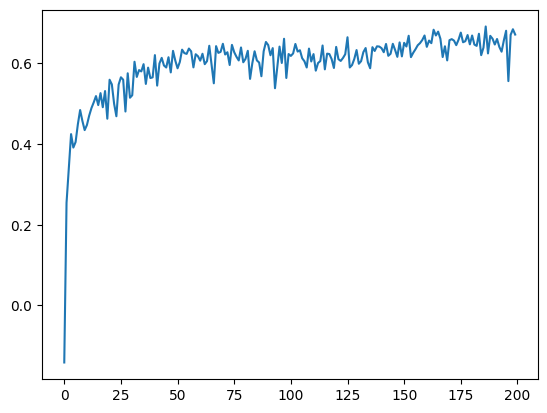

In [133]:
from torch import nn
import torch
import torch.optim as optim
# import cosine similarity 
from torch.nn import CosineSimilarity

for param in model.parameters():
    param.requires_grad = False

for p in model[0].auto_model.embeddings.word_embeddings.parameters():
    p.requires_grad = True
assert any(p.requires_grad for p in model.parameters())

optimizer = optim.Adam(model.parameters(), lr=1)
# scheduler - cosine annealing
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0.0001)
criterion = nn.CosineEmbeddingLoss()
input_ids = torch.tensor([101, new_token_id, 102]).unsqueeze(0)
attention_mask = input_ids != 0
model = model.to("cuda")
input_ids = input_ids.to(model.device)
attention_mask = attention_mask.to(model.device)

best = float("inf")
best_embedding = None
model.train()
sims = []
for epoch in tqdm(range(200)):
    optimizer.zero_grad()
    output = model({
        "input_ids": input_ids,
        "attention_mask": attention_mask,
    })["sentence_embedding"]
    
    loss = criterion(output.squeeze(), target, torch.tensor(1.0))
    loss.backward()
    # set grad of non-new token to 0
    # all ids except new_token_id
    non_new_token_ids = [i for i in range(len(tokenizer.vocab)) if i != new_token_id]
    model[0].auto_model.embeddings.word_embeddings.weight.grad[non_new_token_ids] = 0

    optimizer.step()
    scheduler.step()
    sims.append(1 - loss.item())

    if loss.item() < best:
        best = loss.item()
        best_embedding = model[0].auto_model.embeddings.word_embeddings.weight.data[new_token_id].cpu().numpy()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} Similarity {1 - loss.item()}")
import matplotlib.pyplot as plt
plt.plot(sims)
plt.show()

In [134]:
model.eval()

# get closest tokens
result_embedding = model[0].auto_model.embeddings.word_embeddings.weight.data[new_token_id].cpu().numpy()
cossims = []
for token in tqdm(range(len(tokenizer.vocab))):
    token_embedding = model[0].auto_model.embeddings.word_embeddings.weight.data[token].cpu().numpy()
    cossims.append(CosineSimilarity()(torch.Tensor(token_embedding).unsqueeze(0), torch.Tensor(result_embedding).unsqueeze(0)).item())

100%|██████████| 30522/30522 [00:03<00:00, 8868.31it/s]


In [135]:
# get 10 best
import numpy as np
best_tokens = np.array(cossims).argsort()[-10:][::-1]
best_tokens = [tokenizer.decode([token]) for token in best_tokens]
print(best_tokens)

['[unused179]', 'optimal', 'situations', 'crossbow', 'robust', 'stresses', 'pendulum', 'optimization', 'chaplin', 'problem']


In [143]:
def cosim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
# get new_token_id embedding
result_embedding = model[0].auto_model.embeddings.word_embeddings.weight.data[new_token_id].cpu().numpy()
results = [
    cosim(model.encode(best_token), model.encode(text))
    for best_token in best_tokens
]
indices = np.array(results).argsort()[::-1]

for i in indices:
    print(f"Token: {best_tokens[i]} Similarity: {results[i]}")

Token: optimization Similarity: 0.16684786975383759
Token: crossbow Similarity: 0.16074563562870026
Token: pendulum Similarity: 0.14771604537963867
Token: chaplin Similarity: 0.12216611206531525
Token: stresses Similarity: 0.06618937849998474
Token: situations Similarity: 0.05733662471175194
Token: optimal Similarity: 0.03995447978377342
Token: robust Similarity: 0.016271546483039856
Token: problem Similarity: -0.0335124246776104
Token: [unused179] Similarity: -0.17594529688358307


In [139]:
print(cosim(model.encode(text), model.encode("positioning")))

0.31916875
